##### Giorgi Beridze

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('ggplot')
pd.options.display.max_columns=100
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('csv_files/used_cars.csv')

In [3]:
df.sample(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
3291,Toyota,Tacoma TRD Sport,2018,"84,184 mi.",Gasoline,3.5 Liter,Automatic,Magnetic Gray Metallic,Graphite w/Gun Metal,None reported,NaN,"$35,998"
2681,RAM,2500 Big Horn,2014,"124,700 mi.",Gasoline,410.0HP 6.4L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Silver,–,None reported,Yes,"$30,000"


In [4]:
(df.isna().mean()*100).round(2)

brand            0.00
model            0.00
model_year       0.00
milage           0.00
fuel_type        4.24
engine           0.00
transmission     0.00
ext_col          0.00
int_col          0.00
accident         2.82
clean_title     14.87
price            0.00
dtype: float64

In [5]:
df.nunique()

brand             57
model           1898
model_year        34
milage          2818
fuel_type          7
engine          1146
transmission      62
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

##### remove unwanted columns

In [6]:
df=df.drop(['model','ext_col','int_col','clean_title'],axis=1,errors='ignore')

##### model_year

In [7]:
df['model_year']=df['model_year'].astype(int)

##### milage

In [8]:
df['milage']=df['milage'].apply(lambda x:int(x.split('mi')[0].replace(',','')))

##### fuel type

In [9]:
df['fuel_type'].value_counts(normalize=True)

fuel_type
Gasoline          0.861943
Hybrid            0.050534
E85 Flex Fuel     0.036207
Diesel            0.030216
–                 0.011722
Plug-In Hybrid    0.008856
not supported     0.000521
Name: proportion, dtype: float64

In [10]:
df['fuel_type']=df['fuel_type'].apply(lambda x:
                                      np.nan if str(x).strip()=='–' else 
                                      'electric' if str(x).strip()=='not supported' else x)

##### engine

In [11]:
hp=df['engine'].apply(lambda x:x.split('HP')[0]).apply(pd.to_numeric,errors='coerce')
liters=df['engine'].apply(lambda x:x.split('L')[0].split('Liter')[0].split(' ')[-1]).apply(pd.to_numeric,errors='coerce')

df['HP']=hp
df['Engine Volume (L)']=liters

df=df.drop(columns='engine')

##### transmission

In [12]:
df['transmission']=df['transmission'].str.contains('A/T|Automatic',case=False).astype(str)

##### accident

In [13]:
df['accident']=df['accident'].apply(lambda x:0 if 'None' in str(x) else 1)

##### price

In [14]:
df['price']=df['price'].apply(lambda x:x.replace('$','').replace(',','')).apply(pd.to_numeric)

In [15]:
df

,brand,model_year,milage,fuel_type,transmission,accident,price,HP,Engine Volume (L)
0,Ford,2013,51000,E85 Flex Fuel,True,1,10300,300.0,3.7
1,Hyundai,2021,34742,Gasoline,True,1,38005,NaN,3.8
2,Lexus,2022,22372,Gasoline,True,0,54598,NaN,NaN
3,INFINITI,2015,88900,Hybrid,True,0,15500,354.0,3.5
4,Audi,2021,9835,Gasoline,True,0,34999,NaN,2.0
...,...,...,...,...,...,...,...,...,...
4004,Bentley,2023,714,Gasoline,True,0,349950,NaN,6.0
4005,Audi,2022,10900,Gasoline,False,0,53900,349.0,3.0
4006,Porsche,2022,2116,NaN,True,0,90998,NaN,NaN
4007,Ford,2020,33000,Gasoline,True,0,62999,450.0,3.5


In [16]:
df.isna().mean()*100

brand                 0.000000
model_year            0.000000
milage                0.000000
fuel_type             5.362933
transmission          0.000000
accident              0.000000
price                 0.000000
HP                   20.204540
Engine Volume (L)     9.428785
dtype: float64

In [17]:
df.nunique()

brand                  57
model_year             34
milage               2818
fuel_type               6
transmission            2
accident                2
price                1569
HP                    348
Engine Volume (L)      61
dtype: int64

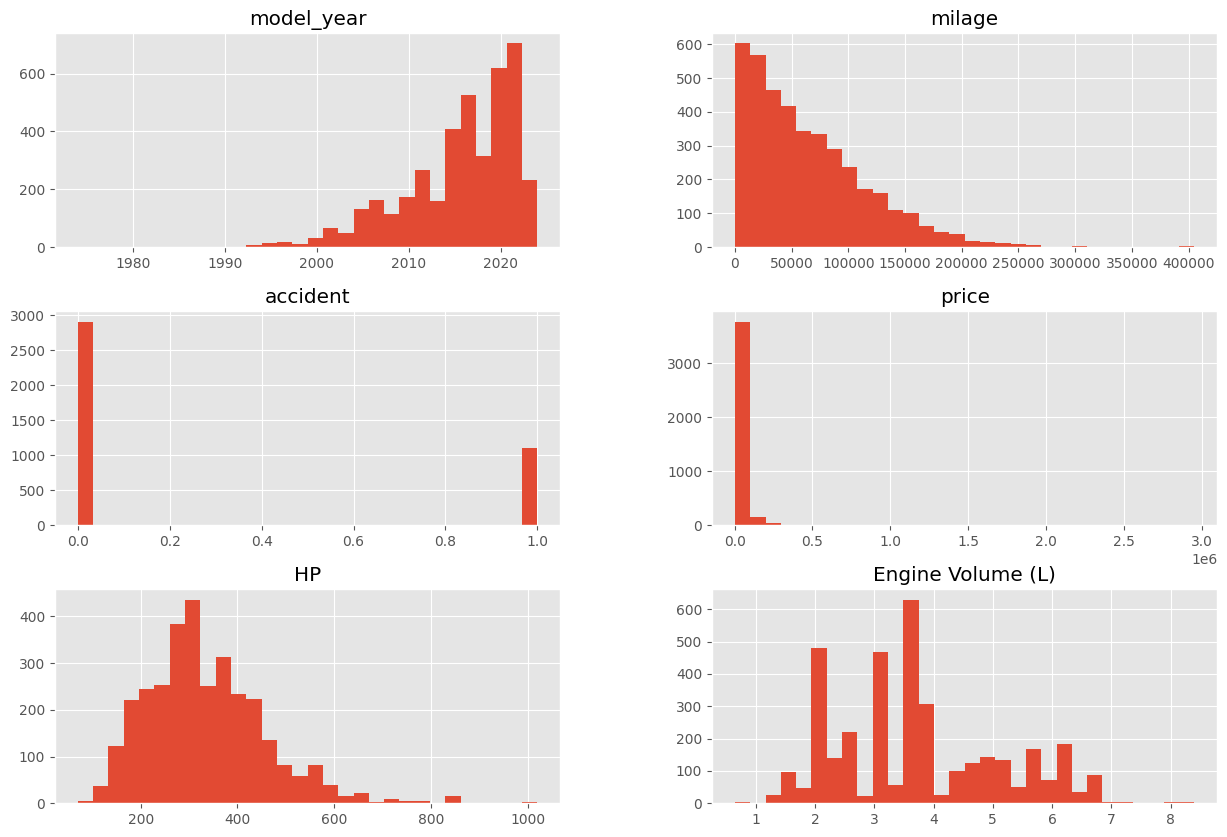

In [18]:
df.hist(figsize=(15,10),bins=30)
plt.show()

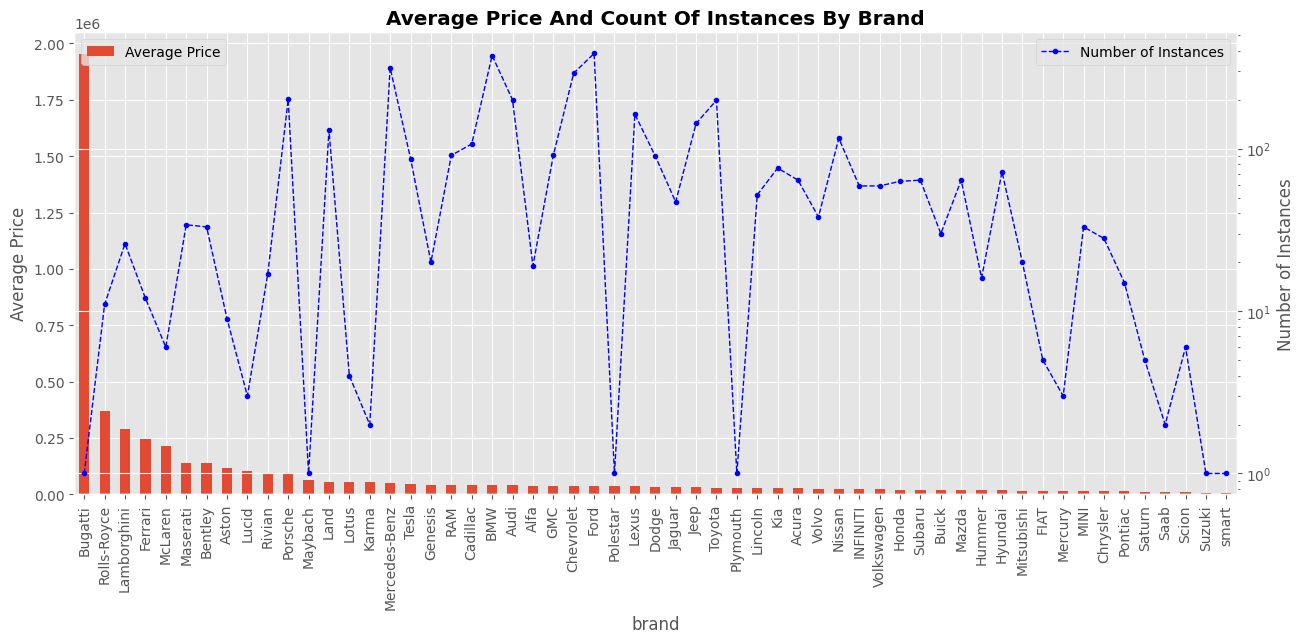

In [19]:
g=df.groupby('brand').agg({'price':['mean','count']}).sort_values(('price','mean'),ascending=False)

fig,ax=plt.subplots(figsize=(15,6))
ax2=ax.twinx()
g.plot.bar(ax=ax,y=('price','mean'),label='Average Price')
g.plot.line(ax=ax2,y=('price','count'),color='blue',ls='--',lw=1,marker='.',label='Number of Instances')
#ax2.axhline(2,ls='--',color='black')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_yscale('log')
ax.set_title('Average Price And Count Of Instances By Brand',fontweight='bold')
ax.set_ylabel('Average Price')
ax2.set_ylabel('Number of Instances')
plt.show()

##### Removing Outliers

In [20]:
df=df.groupby('brand').filter(lambda x:x['price'].count()>2) #remove rare labels

In [21]:
for col in df.select_dtypes([int,float]).columns:
    col_mean=df[col].mean()
    col_std=df[col].std()
    lower_bound=col_mean-2*col_std
    upper_bound=col_mean+2*col_std
    
    df=df[(df[col]<upper_bound)&(df[col]>lower_bound)]

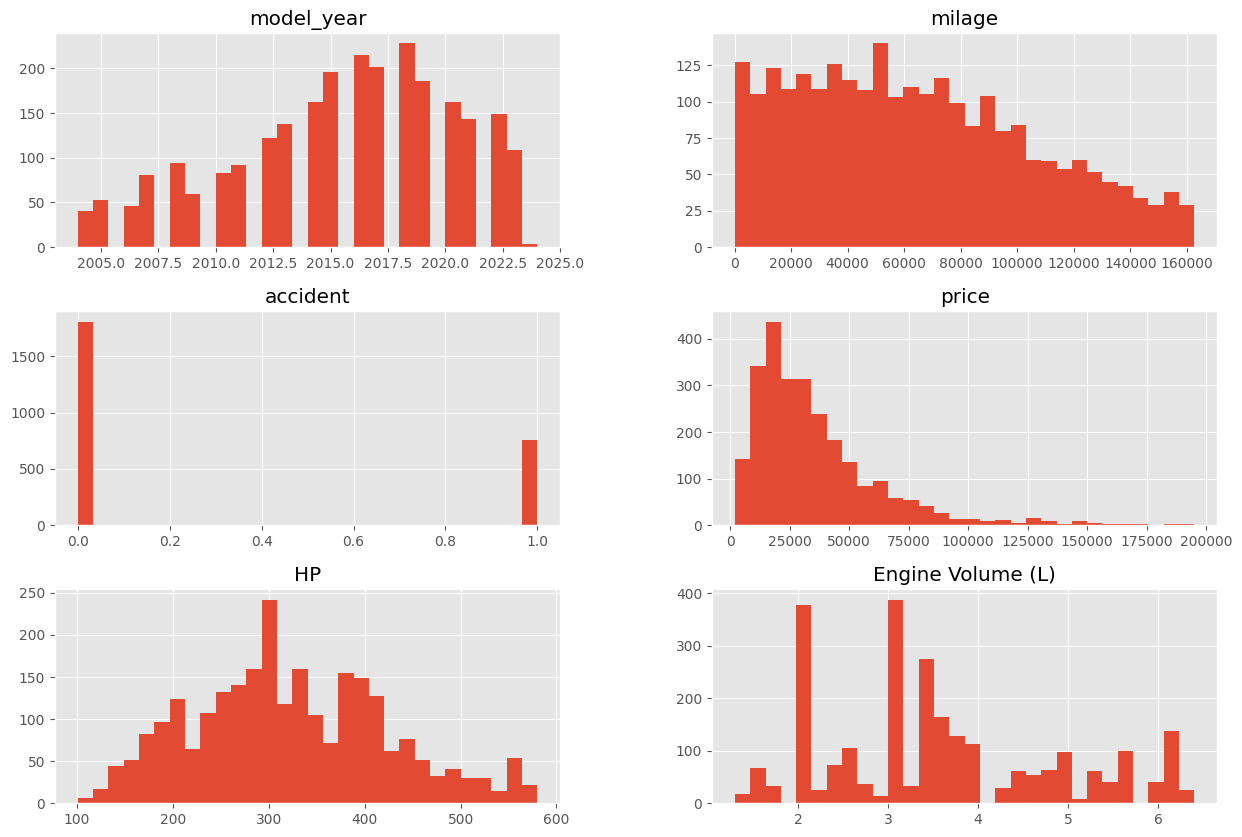

In [22]:
df.hist(figsize=(15,10),bins=30)
plt.show()

##### converting categorical data into dummies

In [23]:
for col in df.select_dtypes('O').columns:
    dummies=pd.get_dummies(df[col],prefix=col,dummy_na=False)
    df=df.drop(columns=col)
    df=pd.concat([df,dummies],axis=1)

In [24]:
df=df.dropna(subset=['HP','Engine Volume (L)'])

In [25]:
df

,model_year,milage,accident,price,HP,Engine Volume (L),brand_Acura,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Buick,brand_Cadillac,brand_Chevrolet,brand_Chrysler,brand_Dodge,brand_FIAT,brand_Ferrari,brand_Ford,brand_GMC,brand_Genesis,brand_Honda,brand_Hummer,brand_Hyundai,brand_INFINITI,brand_Jaguar,brand_Jeep,brand_Kia,brand_Lamborghini,brand_Land,brand_Lexus,brand_Lincoln,brand_Lotus,brand_MINI,brand_Maserati,brand_Mazda,brand_McLaren,brand_Mercedes-Benz,brand_Mercury,brand_Mitsubishi,brand_Nissan,brand_Pontiac,brand_Porsche,brand_RAM,brand_Saturn,brand_Scion,brand_Subaru,brand_Toyota,brand_Volkswagen,brand_Volvo,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,transmission_False,transmission_True
0,2013,51000,1,10300,300.0,3.7,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
3,2015,88900,0,15500,354.0,3.5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
6,2017,84000,0,31000,292.0,2.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
8,2021,23436,0,41927,311.0,3.5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
12,2021,12500,0,53500,382.0,3.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000,2021,32250,1,36000,260.0,2.4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True
4003,2018,53705,1,25900,241.0,2.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
4005,2022,10900,0,53900,349.0,3.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
4007,2020,33000,0,62999,450.0,3.5,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [26]:
X=df.drop(columns='price')
y=df['price']

#stratify_cols=df.columns[df.columns.str.contains('brand_')]

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [27]:
from xgboost import XGBRegressor

In [28]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model):
    train_sizes,train_scores,test_scores=learning_curve(
        X=X_train,
        y=y_train,
        estimator=model,
        train_sizes=np.linspace(0.1,1,10),
        cv=3,
        scoring='neg_root_mean_squared_error',
        verbose=1
    )
    
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy', color='red')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('MAE')
    plt.title('Learning Curve for XGBoost Classifier')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

[learning_curve] Training set sizes: [ 136  273  410  547  684  820  957 1094 1231 1368]


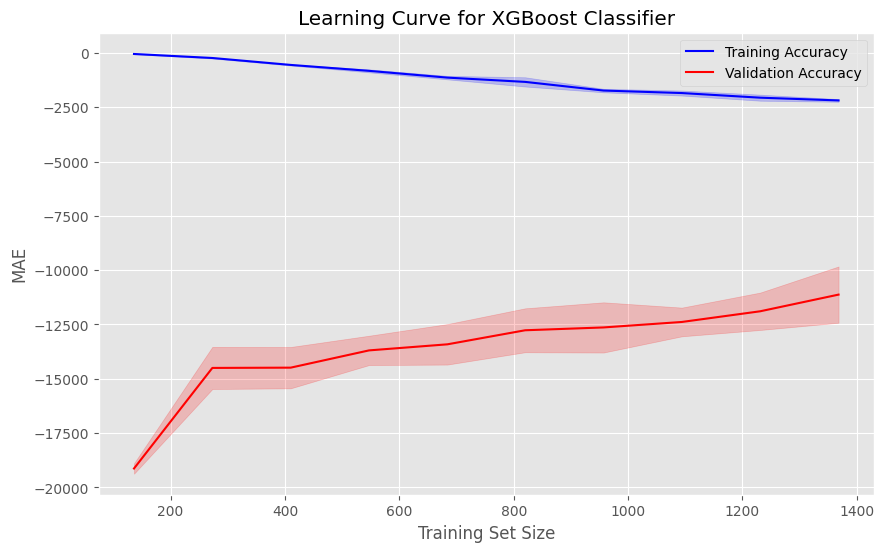

In [29]:
plot_learning_curve(XGBRegressor()) #initial model

In [30]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[100,500,1000,2000],
            'max_depth':[3,5,8,10],
            'learning_rate':[0.01,0.05,0.1,0.15]}

grid_search_cv=GridSearchCV(estimator=XGBRegressor(),
                         param_grid=param_grid,
                         scoring='neg_root_mean_squared_error',
                         cv=3,
                         verbose=10)

grid_search_cv.fit(X_train,y_train)

best_model=grid_search_cv.best_estimator_
print(grid_search_cv.best_estimator_)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-20140.522 total time=   0.2s
[CV 2/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-17220.446 total time=   0.1s
[CV 3/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-17054.118 total time=   0.1s
[CV 1/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 1/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-13713.063 total time=   0.6s
[CV 2/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 2/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-11887.730 total time=   0.5

[learning_curve] Training set sizes: [ 136  273  410  547  684  820  957 1094 1231 1368]


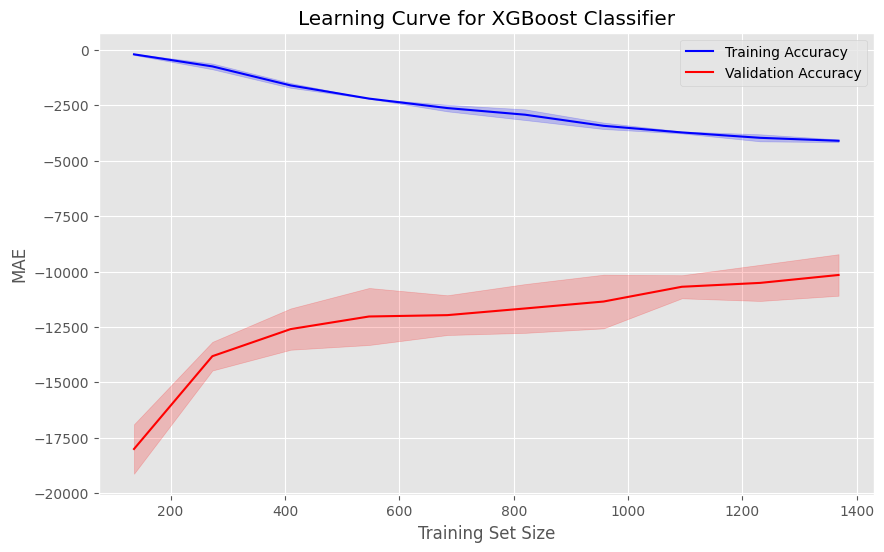

In [31]:
plot_learning_curve(best_model)

In [32]:
train_prediction=best_model.predict(X_train)
test_prediction=best_model.predict(X_test)

In [33]:
from sklearn import metrics

r2_train=metrics.r2_score(train_prediction,y_train)
r2_test=metrics.r2_score(test_prediction,y_test)
mae_train=metrics.mean_absolute_error(train_prediction,y_train)
mae_test=metrics.mean_absolute_error(test_prediction,y_test)
rmse_train=metrics.mean_squared_error(train_prediction,y_train,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.9639953362685036, 'MAE_train': 3440.1218039340297, 'RMSE_train': 4994.735683497241}
{'R2_test': 0.8704387718266908, 'MAE_test': 6064.450795926937, 'RMSE_test': 9058.884395927056}


##### Error Analysis

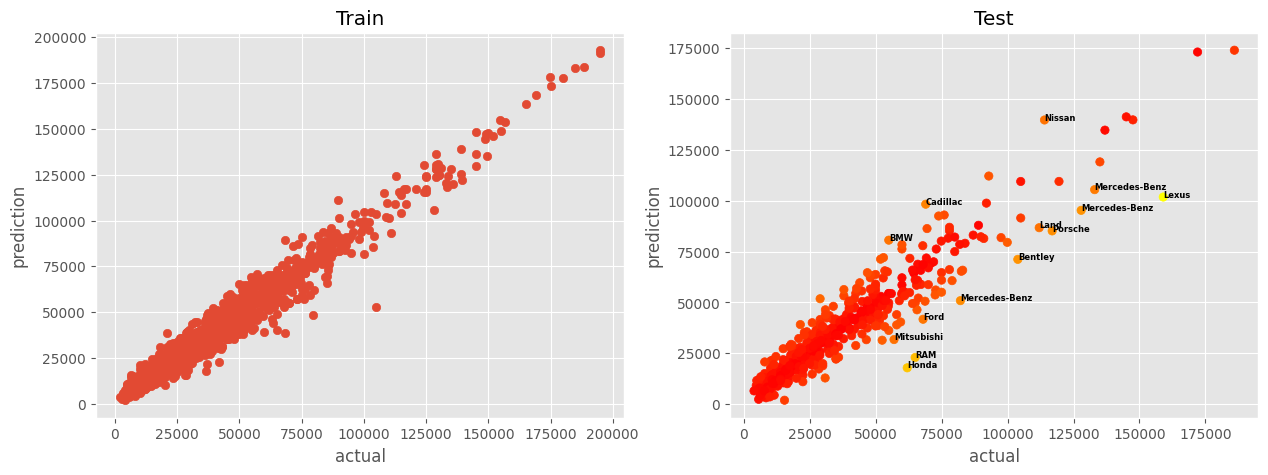

In [34]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(y_train,train_prediction)
ax1.set_xlabel('actual')
ax1.set_ylabel('prediction')
ax1.set_title('Train')
ax2.scatter(y_test,test_prediction,c=(y_test-test_prediction).abs(),cmap='autumn')
ax2.set_xlabel('actual')
ax2.set_ylabel('prediction')
ax2.set_title('Test')


brands=X_test[X_test.columns[X_test.columns.str.contains('brand_')]].idxmax(axis=1).str.replace('brand_','')
absolute_error=(y_test-test_prediction).abs()
#plot text
for error,actual,prediction,brand in zip(absolute_error,y_test,test_prediction,brands):
    if error<mae_test-2*rmse_test or error>mae_test+2*rmse_test:
        ax2.text(actual,prediction,brand,fontweight='bold',size=6)
    
plt.show()

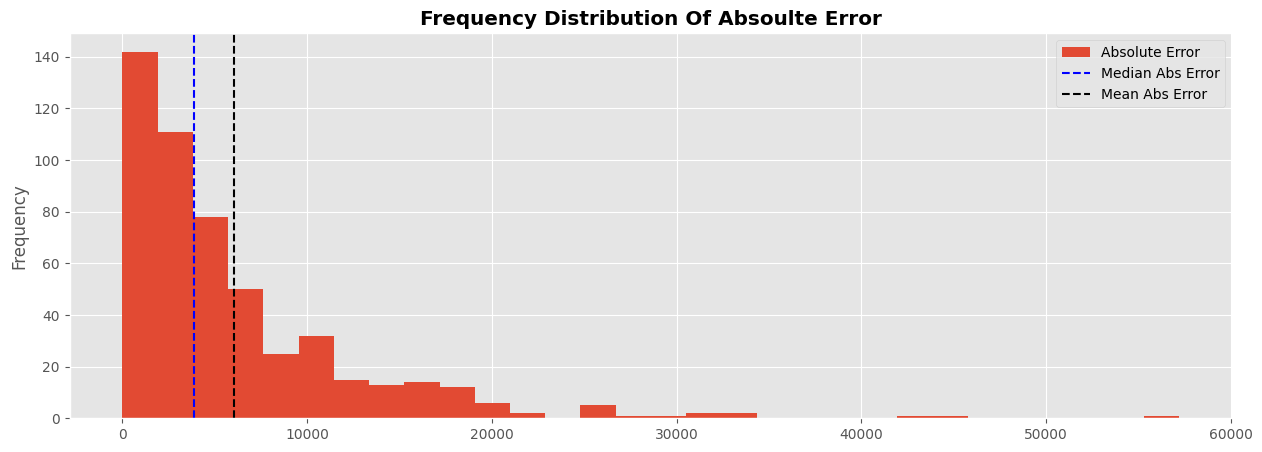

In [35]:
fig,ax=plt.subplots(figsize=(15,5))
absolute_error.plot.hist(ax=ax,bins=30,label='Absolute Error')
ax.set_title('Frequency Distribution Of Absoulte Error',fontweight='bold')
median_abs_error=absolute_error.median()
ax.axvline(median_abs_error,label='Median Abs Error',color='blue',ls='--')
ax.axvline(mae_test,label='Mean Abs Error',color='black',ls='--')
ax.legend()
plt.show()

In [36]:
# there are a few individual cases, that increase mean absolute error
# median absolute error is significanly lower than mean absolute error

In [37]:
X_test_new=X_test.copy()

dummie_column_keywords=['brand_','fuel_type_','transmission_']
for dummie_column_keyword in dummie_column_keywords:
    dummie_columns=X_test_new.columns[X_test_new.columns.str.contains(dummie_column_keyword)]
    dummie_to_series=X_test_new[dummie_columns].idxmax(axis=1).str.replace(dummie_column_keyword,'')
    dummie_to_series_df=pd.DataFrame({dummie_column_keyword:dummie_to_series})
    X_test_new=X_test_new.drop(columns=dummie_columns)
    X_test_new=pd.concat([X_test_new,dummie_to_series_df],axis=1)

In [38]:
X_test_new['Absolute Error']=absolute_error

In [39]:
X_test_new

,model_year,milage,accident,HP,Engine Volume (L),brand_,fuel_type_,transmission_,Absolute Error
737,2014,80211,1,300.0,3.0,BMW,Gasoline,True,1834.646484
3044,2010,77400,1,416.0,5.0,Lexus,Gasoline,True,4251.359375
3487,2011,20000,0,276.0,3.5,Lotus,Gasoline,False,2441.105469
1463,2008,125470,0,360.0,4.8,BMW,Gasoline,True,7120.237305
1907,2013,104994,0,199.0,2.4,Kia,Hybrid,True,2983.409180
...,...,...,...,...,...,...,...,...,...
3776,2009,81327,0,355.0,6.0,Pontiac,Gasoline,False,10929.302734
404,2018,110380,1,316.0,2.0,Volvo,Gasoline,True,4882.544922
1871,2018,45578,0,375.0,3.5,Ford,Gasoline,True,6006.542969
991,2019,36000,1,335.0,3.0,BMW,Gasoline,True,585.265625


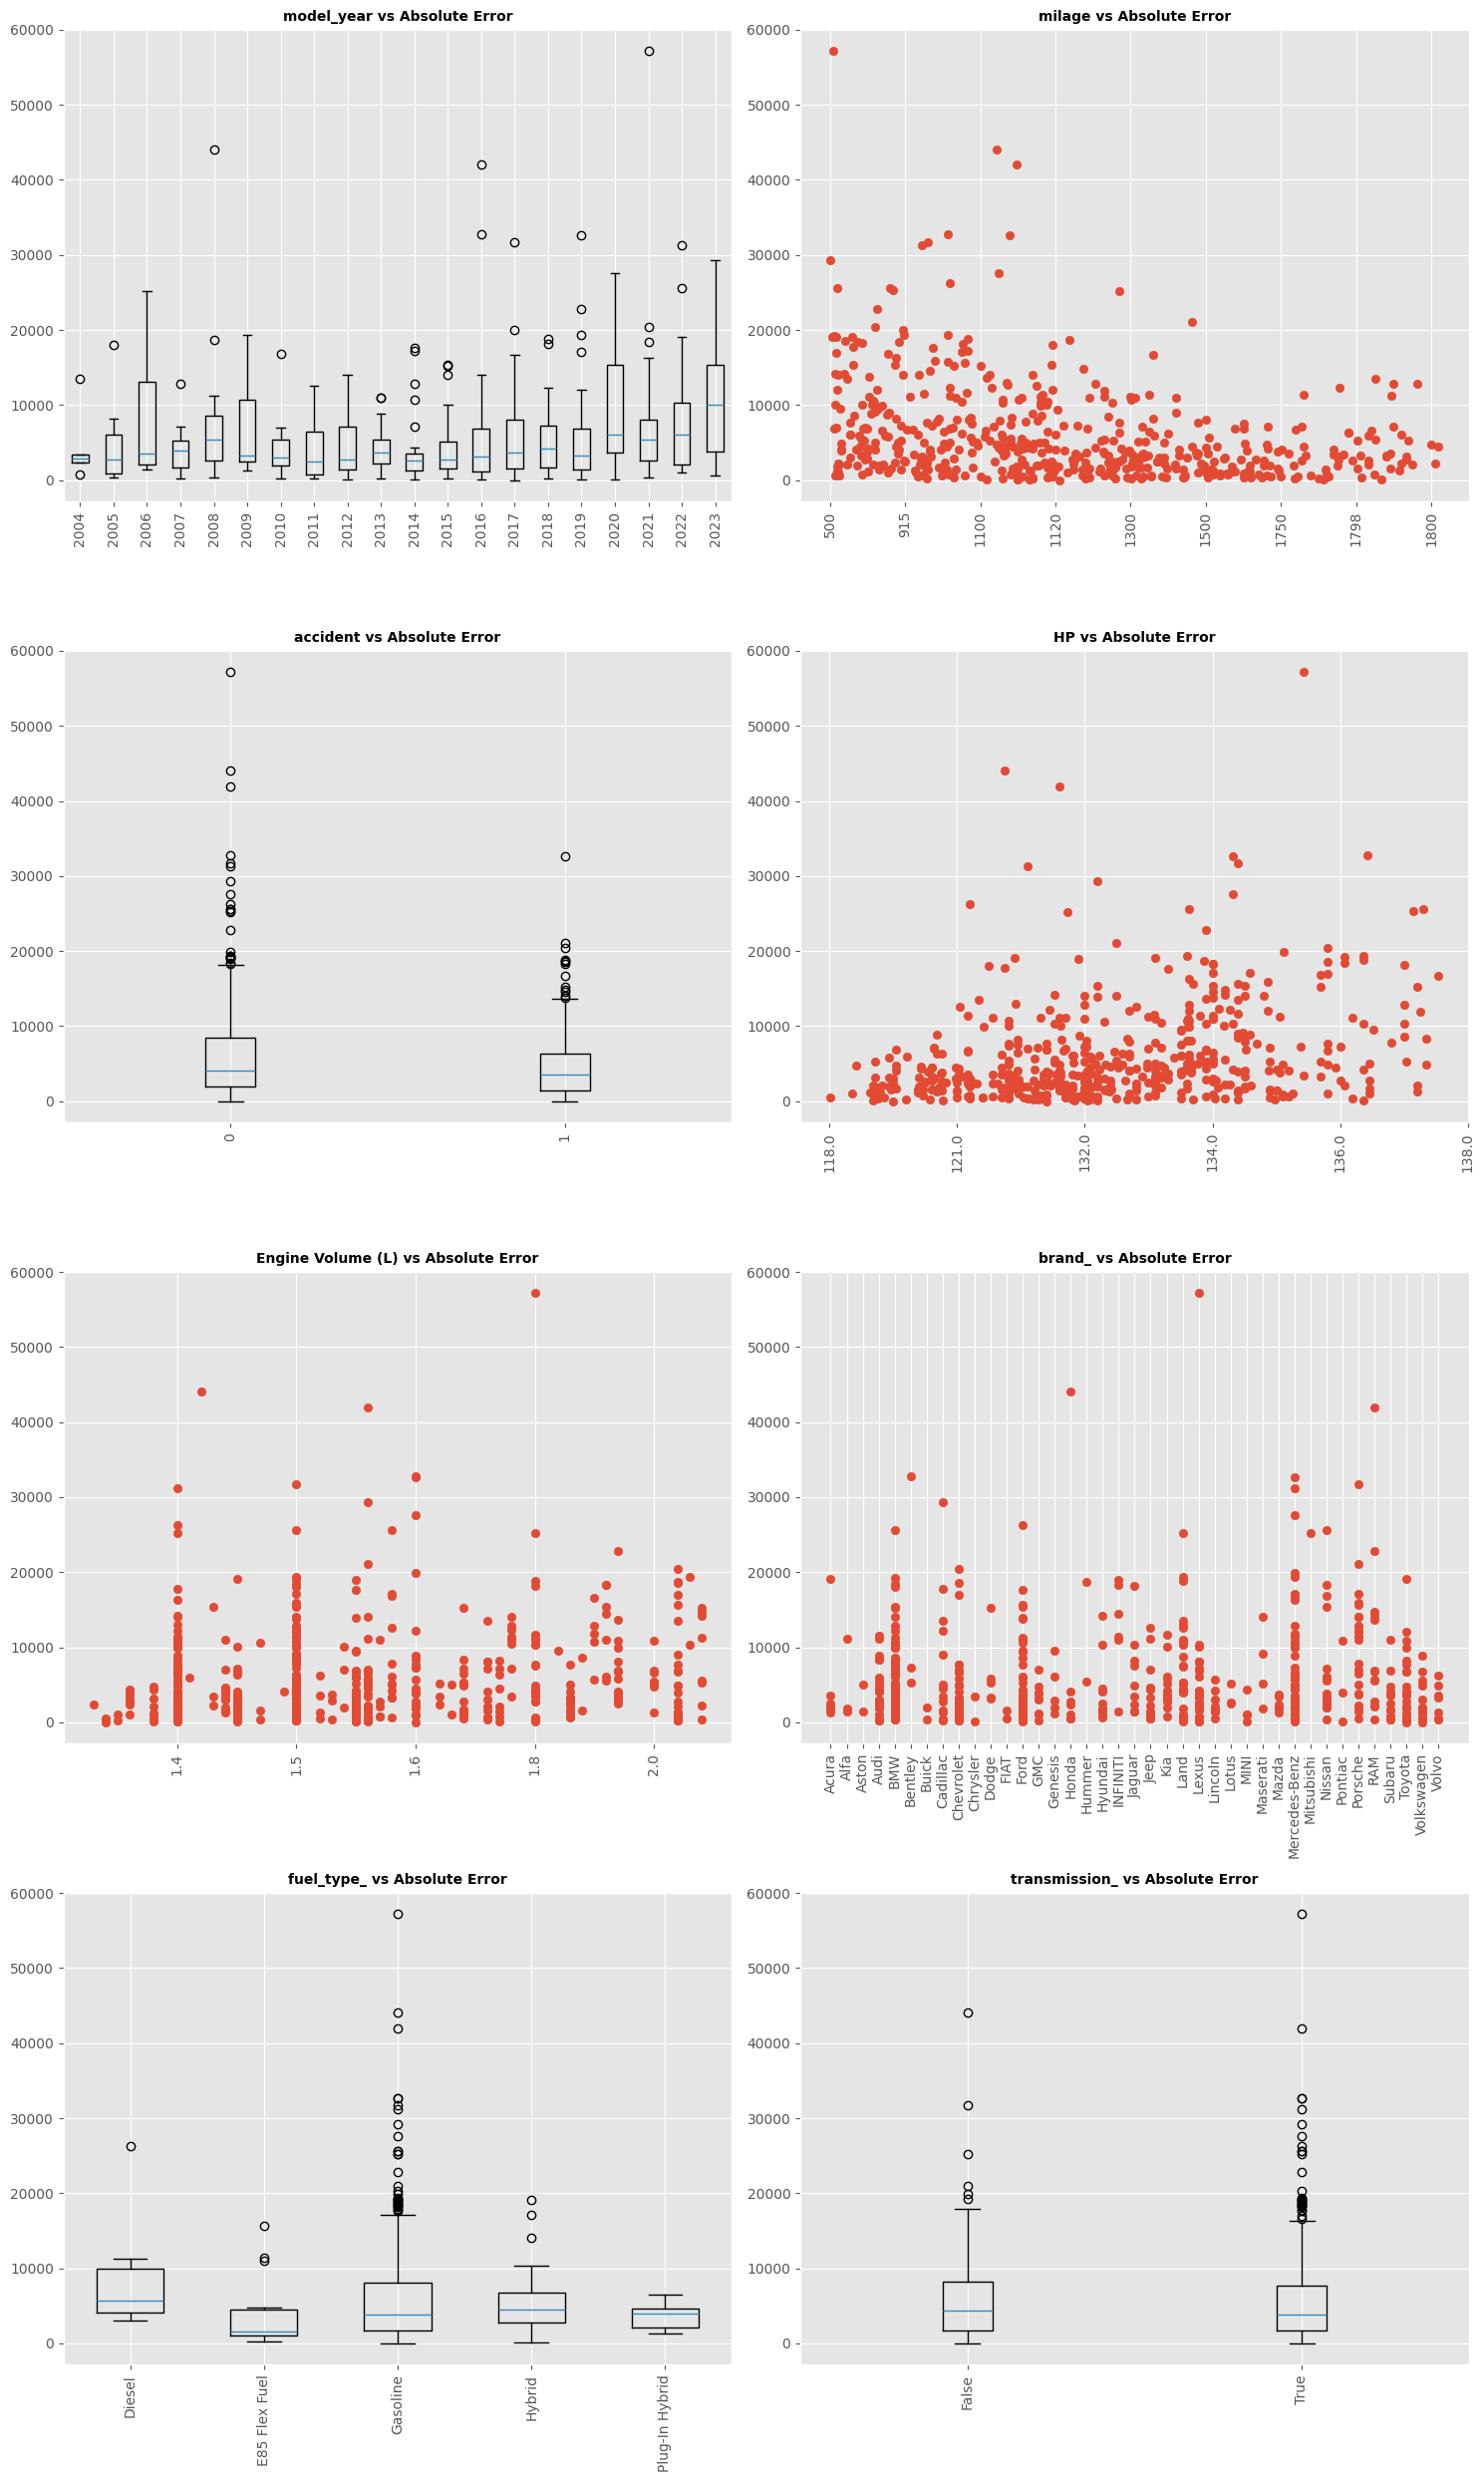

In [40]:
fig,axes=plt.subplots(4,2,figsize=(15,25))

for col,ax in zip(X_test_new.columns,axes.ravel()):
    X_test_new=X_test_new.sort_values(col)
    if X_test_new[col].nunique()<=25:
        ax.boxplot(labels=X_test_new[col].unique(),
                   x=[X_test_new[X_test_new[col]==label]['Absolute Error'] for label in X_test_new[col].unique()])
        ax.set_title(f'{col} vs Absolute Error',fontweight='bold',size=10)
        ax.set_xticklabels(X_test_new[col].unique(),rotation=90)
    else:
        ax.scatter(x=X_test_new[col],y=X_test_new['Absolute Error'])
        ax.set_title(f'{col} vs Absolute Error',fontweight='bold',size=10)
        ax.set_xticklabels(X_test_new[col].unique(),rotation=90)

#plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()